In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

In [3]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name, start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')):
    df = yf.download(stock_name.upper(),
                     start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                     end=datetime.today().strftime('%Y-%m-%d'))
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    low_clusters = get_optimum_clusters(df[(df['Low']!=df['Open'])&(df['Low']!=df['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df[(df['High']!=df['Open'])&(df['High']!=df['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df['High'].max()
        
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')

    df['9_MA'] = df['Close'].rolling(window=9).mean()
    df['20_MA'] = df['Close'].rolling(window=20).mean()
    df['50_MA'] = df['Close'].rolling(window=50).mean()

    ax.plot(df['Date'], df['Close'], color='black')
    ax.plot(df['Date'], df['9_MA'], ls='--')
    ax.plot(df['Date'], df['20_MA'], ls='--')
    ax.plot(df['Date'], df['50_MA'], ls='--')
    


QQQ

2023-09-27

* previous stock price closing 354.21 ~ up 356.59 , down 353.56
* Break / reflect at support / resistance

* ITM option traded price: call (, expire 9/22), 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 355.04 ~ up 356.61 , down 353.72
[[261.78476315]
 [270.20166651]
 [280.01724348]
 [290.95933329]
 [304.09455039]
 [316.82290256]
 [332.90222168]
 [353.72714233]
 [364.97028721]
 [375.71356964]]
[[268.11762056]
 [276.27761841]
 [285.35515155]
 [296.33793167]
 [309.89291509]
 [321.38839033]
 [336.72285679]
 [356.60647044]
 [368.57305484]
 [379.61677404]]


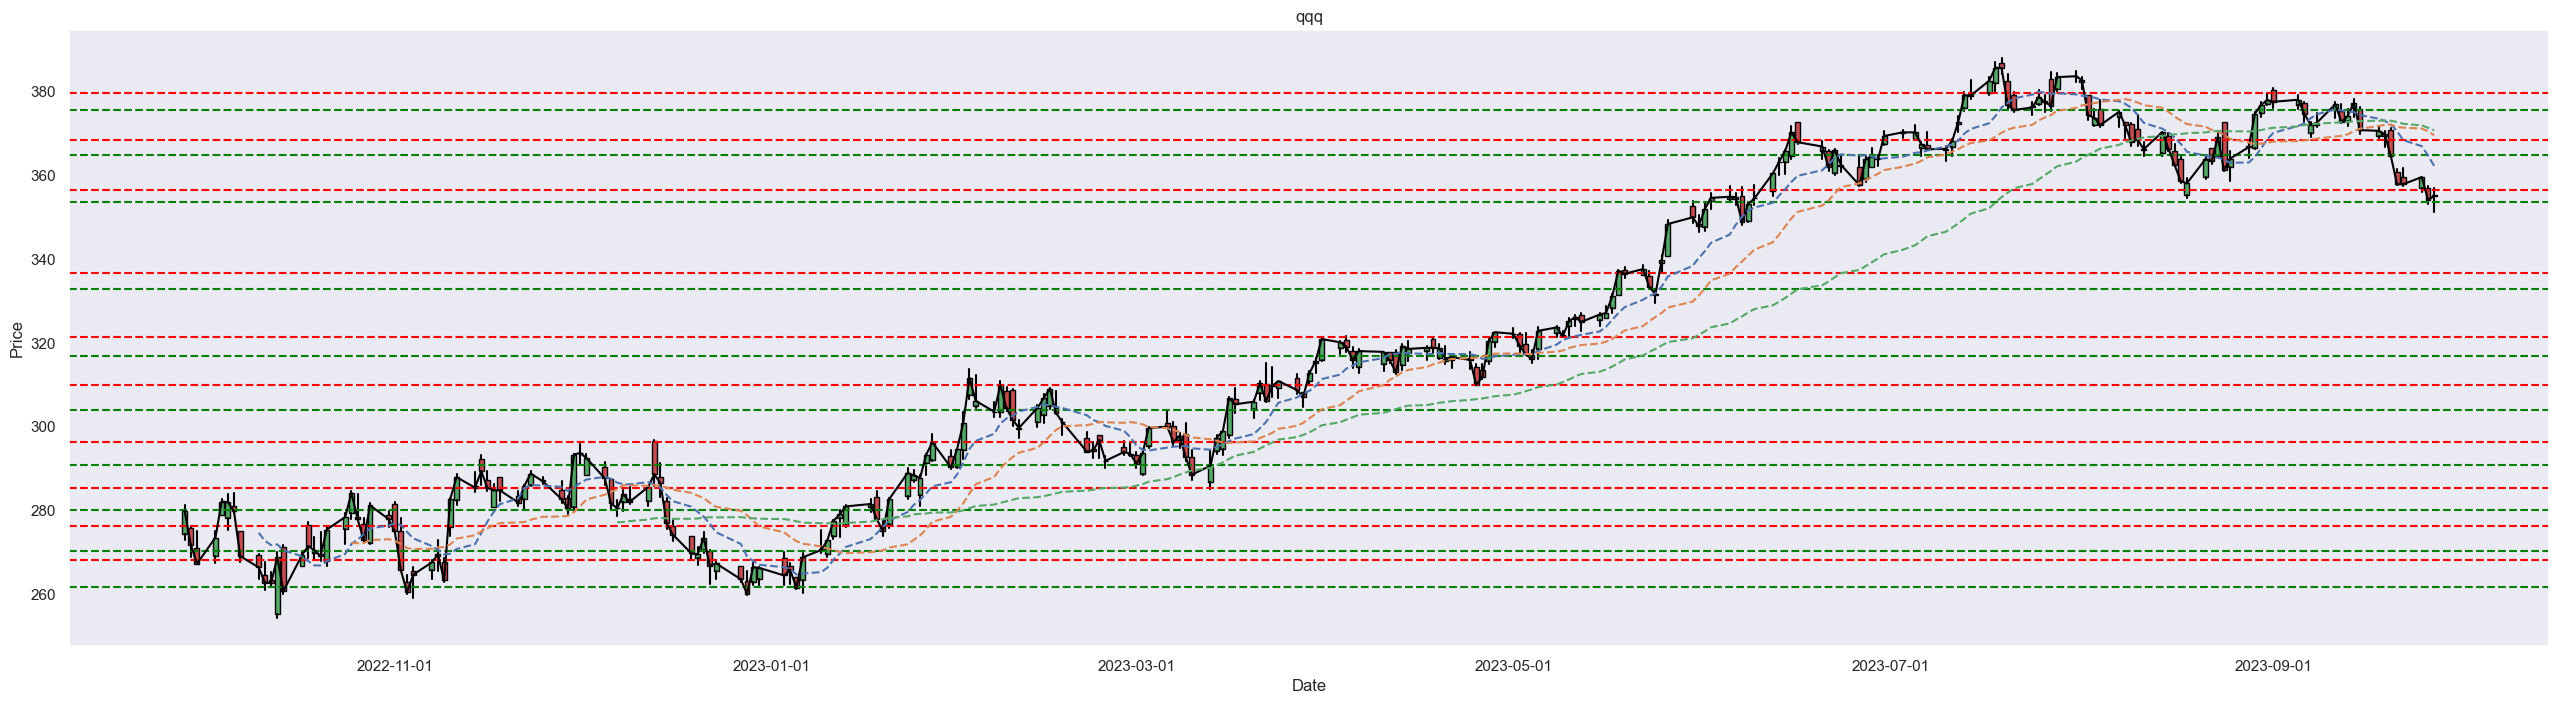

In [4]:
test_option_trading('qqq')

SPY 

2023-09-27
* previous stock price closing 425.9 ~ up 434.0 , down 411.0

* Break / reflect at support / resistance: reflect at support 431

* ITM option traded price: call (strike 432, expire 9/29), 3.92 

* Option profitability EOD: 3.21; highest after: 4.8

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 426.05 ~ up 433.92 , down 426.0
[[359.95687294]
 [376.73192186]
 [385.93875313]
 [394.01214309]
 [402.65880005]
 [410.75795607]
 [426.0033315 ]
 [434.95545543]
 [442.87307622]
 [450.82454196]]
[[369.30875206]
 [382.80499961]
 [390.72937584]
 [398.41947535]
 [405.36348028]
 [412.8805277 ]
 [418.82266642]
 [433.91304082]
 [444.54551644]
 [453.52111138]]


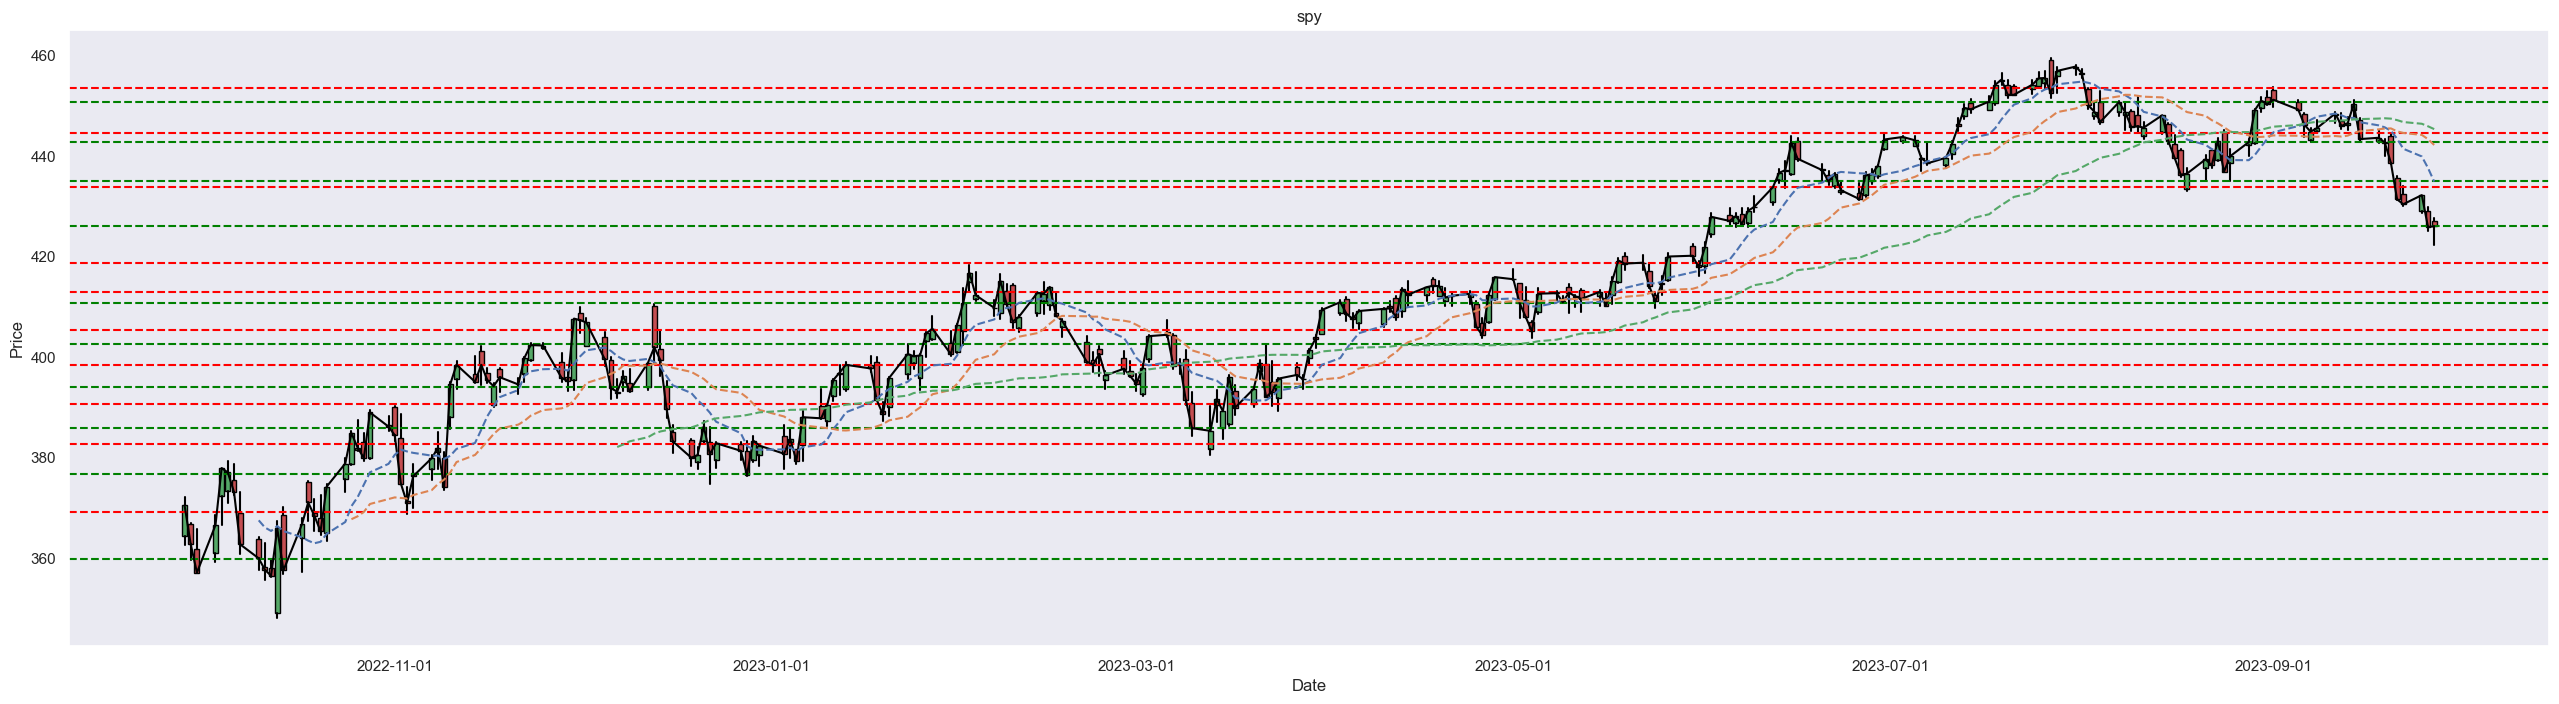

In [5]:
test_option_trading('spy')

GOOGL 

2023-09-27
* previous stock price closing 128.6 ~ up 131.3 , down 122.3

* Break / reflect at support / resistance: resistance 131

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 130.54 ~ up 131.31 , down 128.84
[[ 86.35166634]
 [ 89.94359985]
 [ 93.71866633]
 [ 96.70461537]
 [100.15000007]
 [104.45718741]
 [117.73571523]
 [122.26199977]
 [128.84107208]
 [134.91785649]]
[[ 88.98476265]
 [ 92.559566  ]
 [ 96.35840027]
 [ 99.82371412]
 [103.29473636]
 [107.29419314]
 [120.01388931]
 [124.68193596]
 [131.30806265]
 [137.2914287 ]]


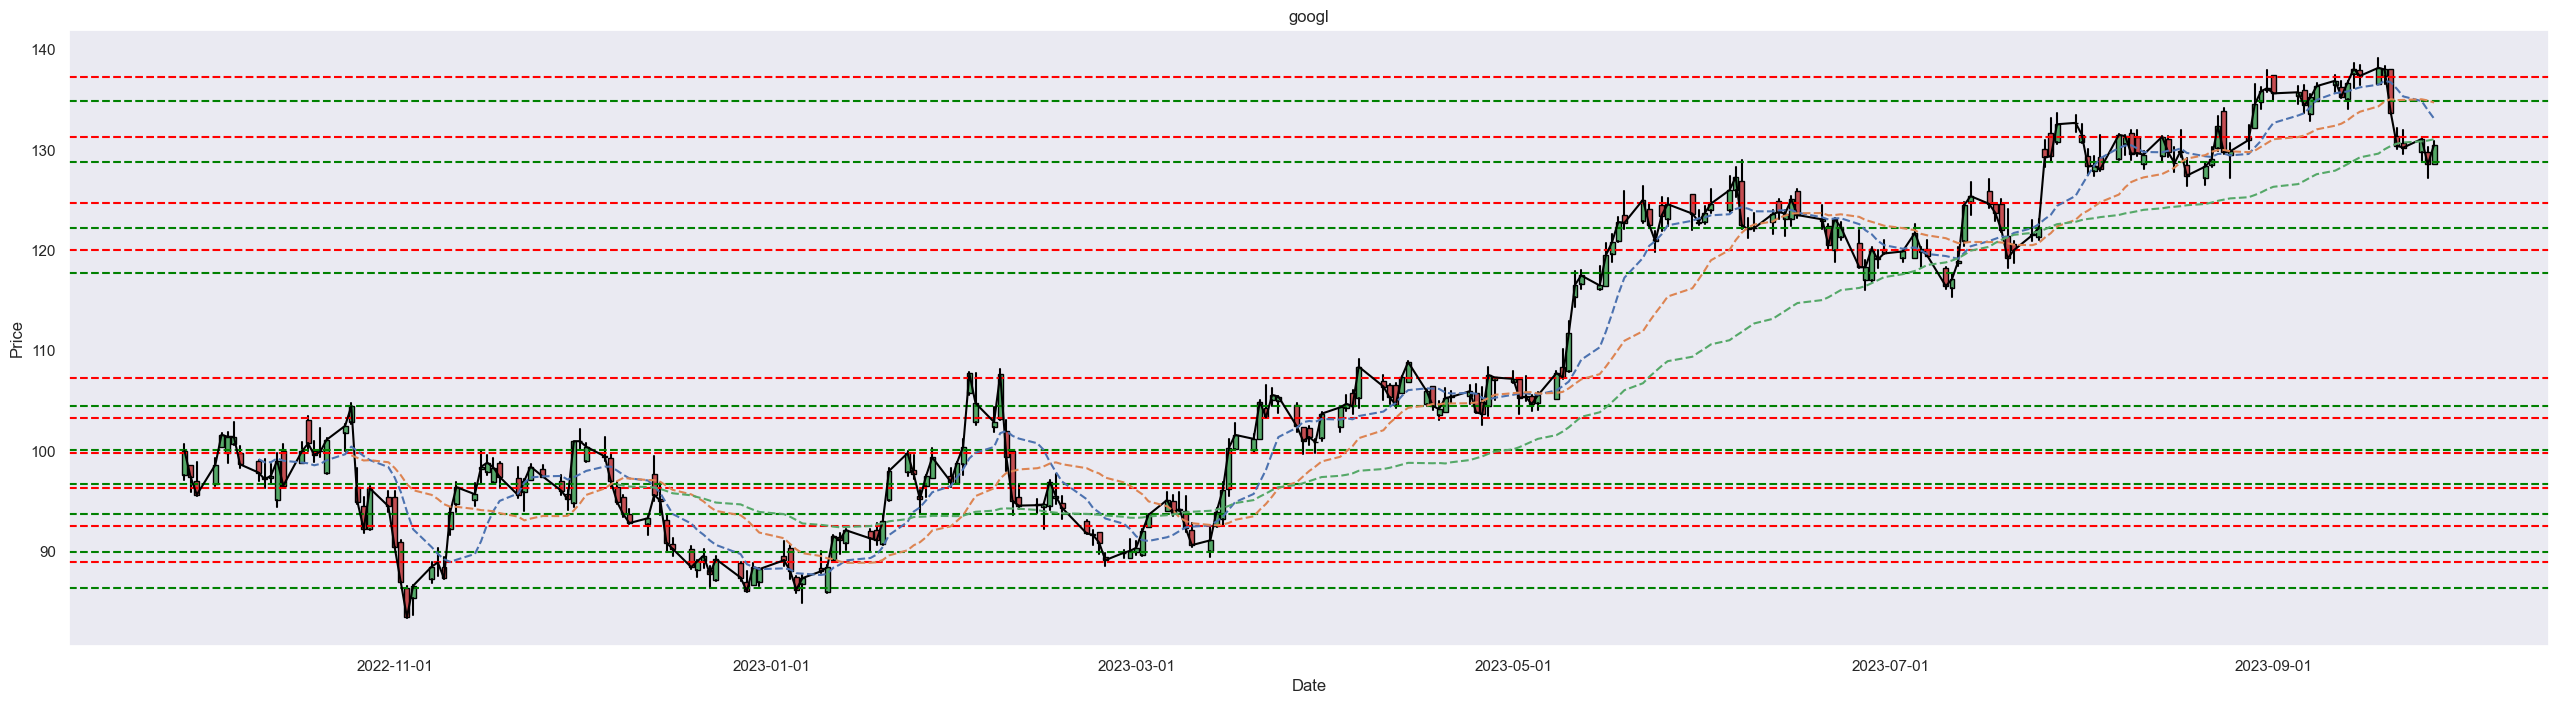

In [6]:
test_option_trading('googl')

MSFT

2023-09-27
* previous stock price closing 312.1 ~ up 312.4 , down 306.8

* Break / reflect at support / resistance: support 320.4

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 312.79 ~ up 327.05 , down 307.01
[[223.2178947 ]
 [234.89242323]
 [244.15289467]
 [255.58090695]
 [271.5469196 ]
 [284.25900421]
 [307.0152911 ]
 [319.36961247]
 [329.42820388]
 [339.5742885 ]]
[[230.98666745]
 [242.4026195 ]
 [251.83272576]
 [262.41466675]
 [277.9050045 ]
 [289.16000027]
 [312.44636397]
 [327.04433289]
 [337.85046458]
 [353.60499878]]


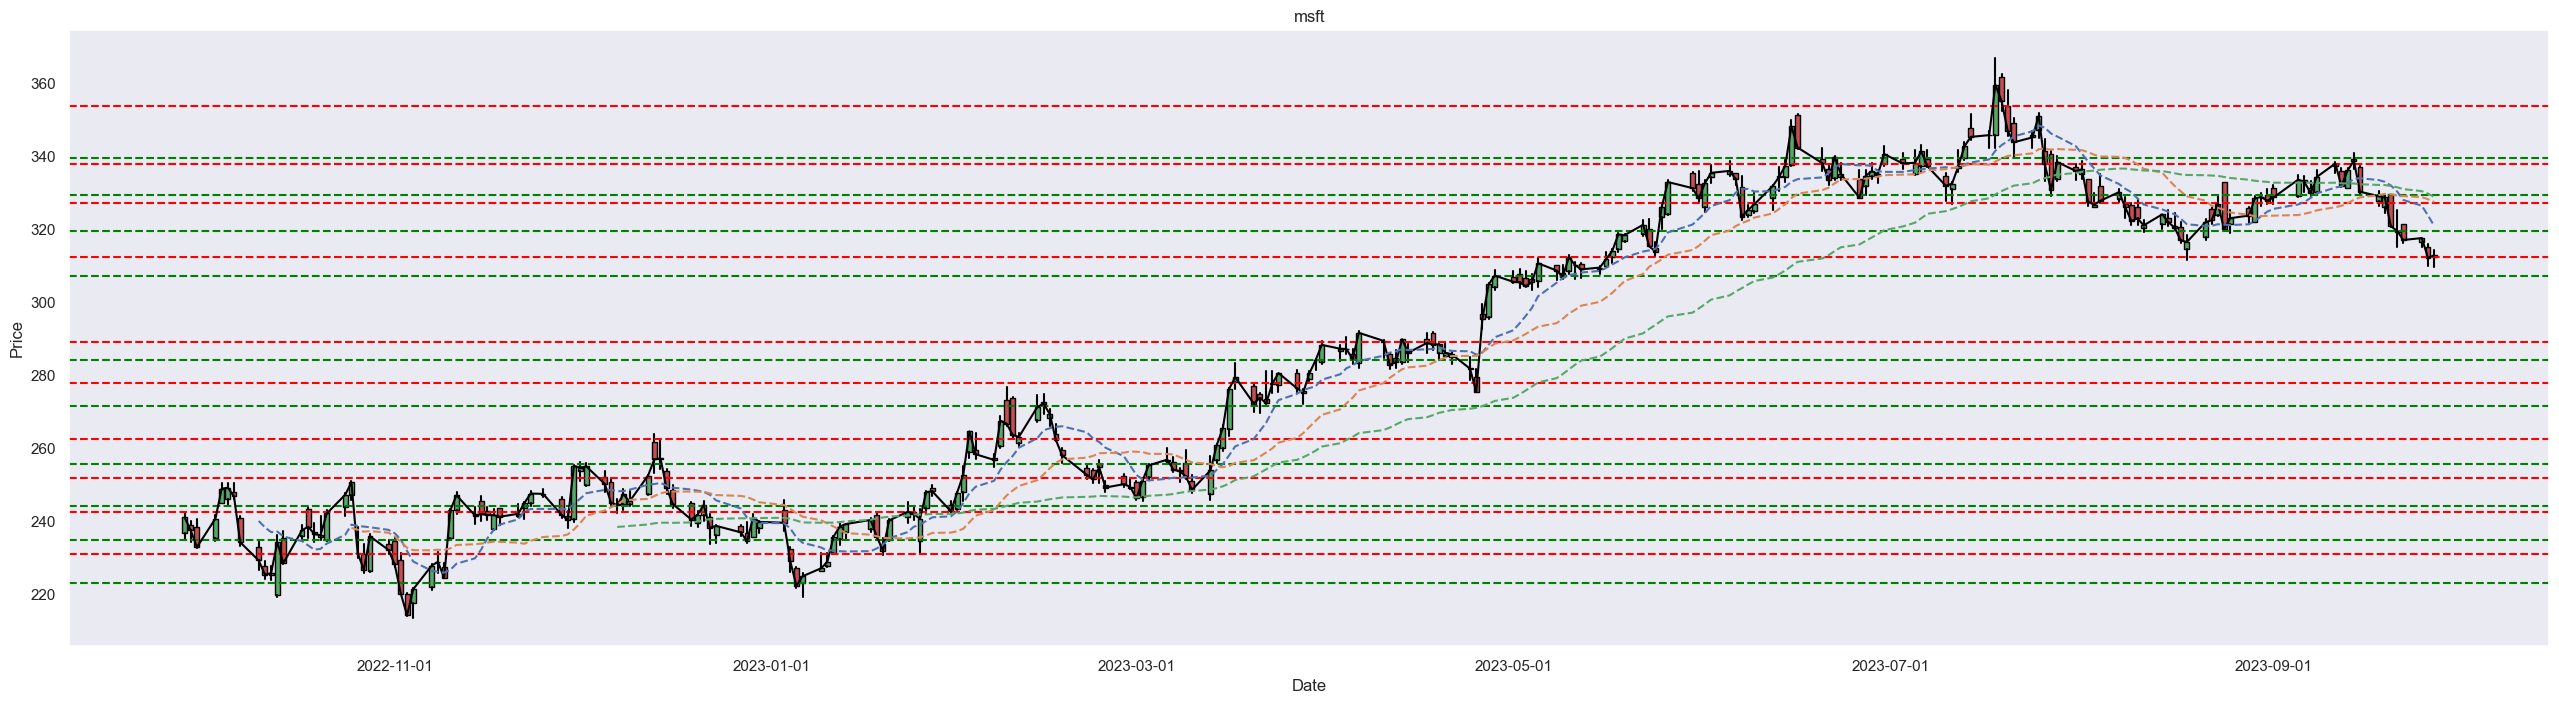

In [7]:
test_option_trading('msft')

TSLA

2023-09-27
* previous stock price closing 244.1 ~ up 246.0 , down 241.4

* Break / reflect at support / resistance: 

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 240.5 ~ up 245.99 , down 222.8
[[113.58666636]
 [133.65000229]
 [161.96514195]
 [178.780263  ]
 [191.51999931]
 [207.85350037]
 [222.80000051]
 [241.21724096]
 [257.88366801]
 [274.80562592]]
[[121.40799917]
 [140.72666592]
 [167.12714222]
 [183.83675694]
 [196.79552701]
 [211.5371428 ]
 [227.54826222]
 [245.98818207]
 [262.10968733]
 [280.69960083]]


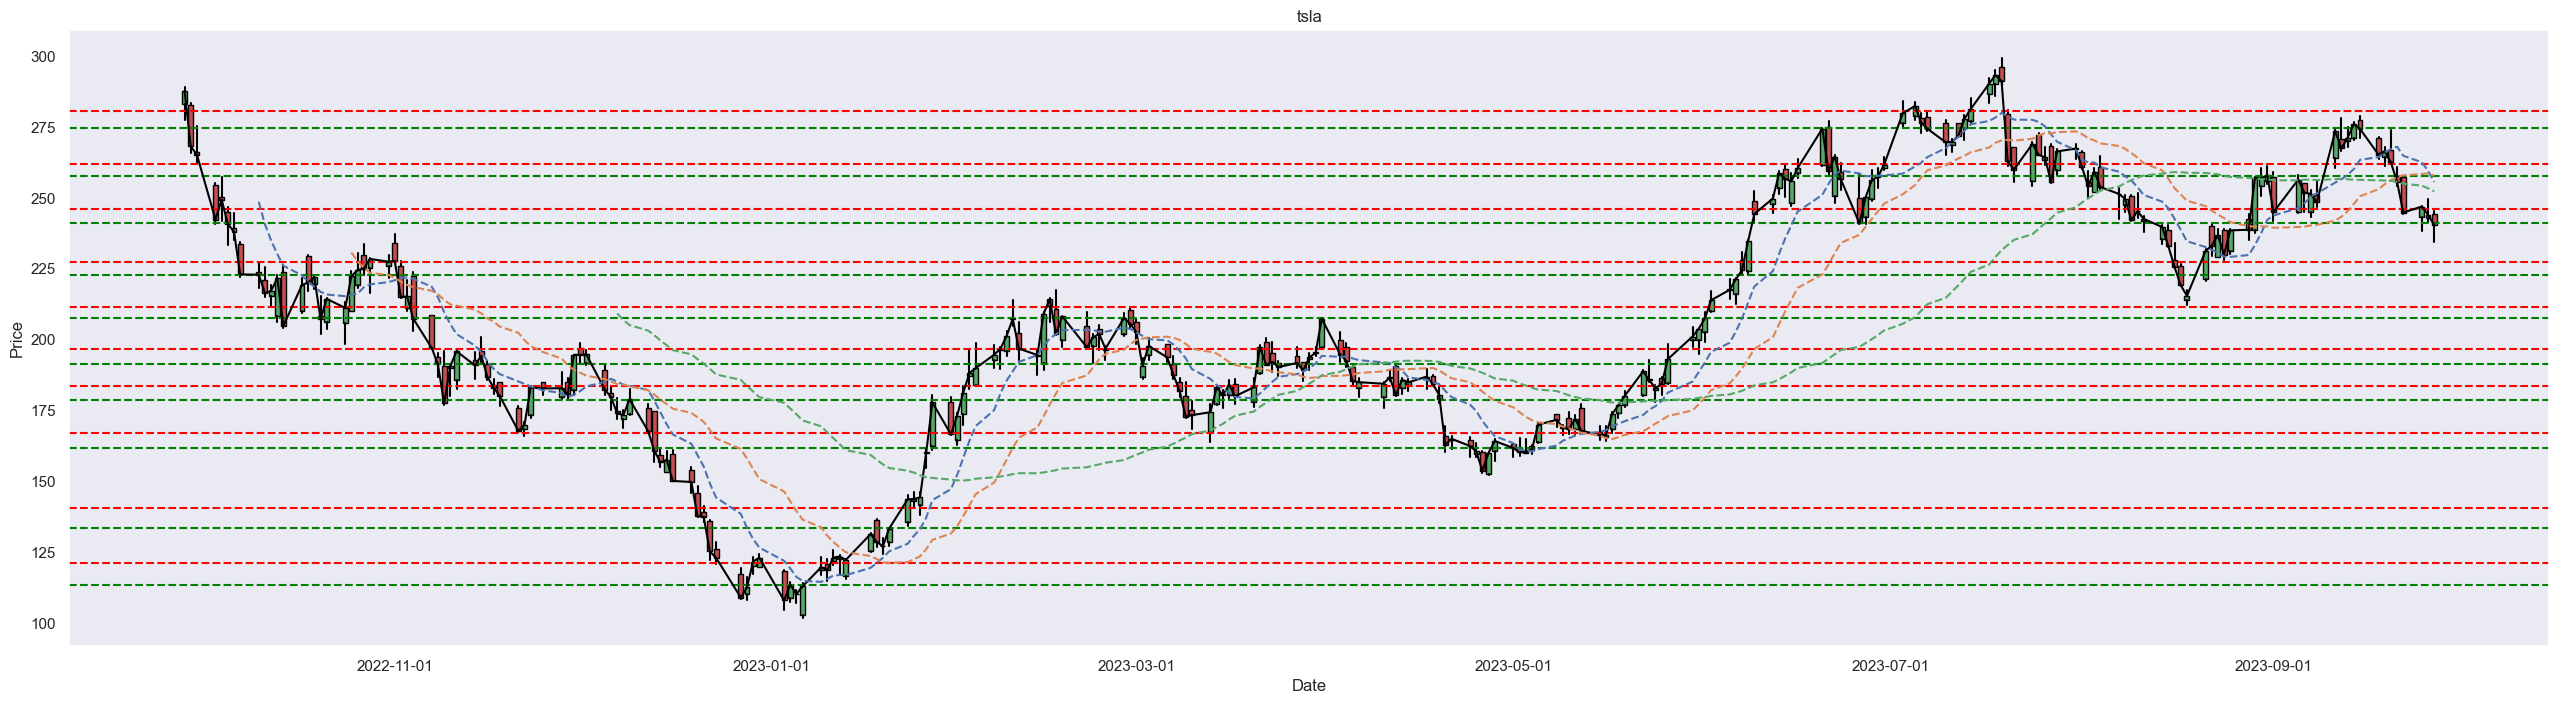

In [8]:
test_option_trading('tsla')

COF 

2023-09-27

* previous stock price closing 97.1 ~ up 98.3 , down 96.2

* Break / reflect at support / resistance: break support 99.1

* ITM option traded price: put (99, expire 9/29) 1.75 

* Option profitability EOD: 1.85; highest 2 

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 95.49 ~ up 95.6 , down 93.36
[[ 86.47166697]
 [ 89.97434832]
 [ 93.36189249]
 [ 96.22769194]
 [ 99.12757619]
 [101.82625008]
 [105.09250069]
 [108.3151847 ]
 [111.53000107]
 [115.09560028]]
[[ 89.4700002 ]
 [ 92.75250053]
 [ 95.59636388]
 [ 98.91575031]
 [102.56473702]
 [105.75280029]
 [109.98607172]
 [113.67857179]
 [116.86999969]
 [120.11299973]]


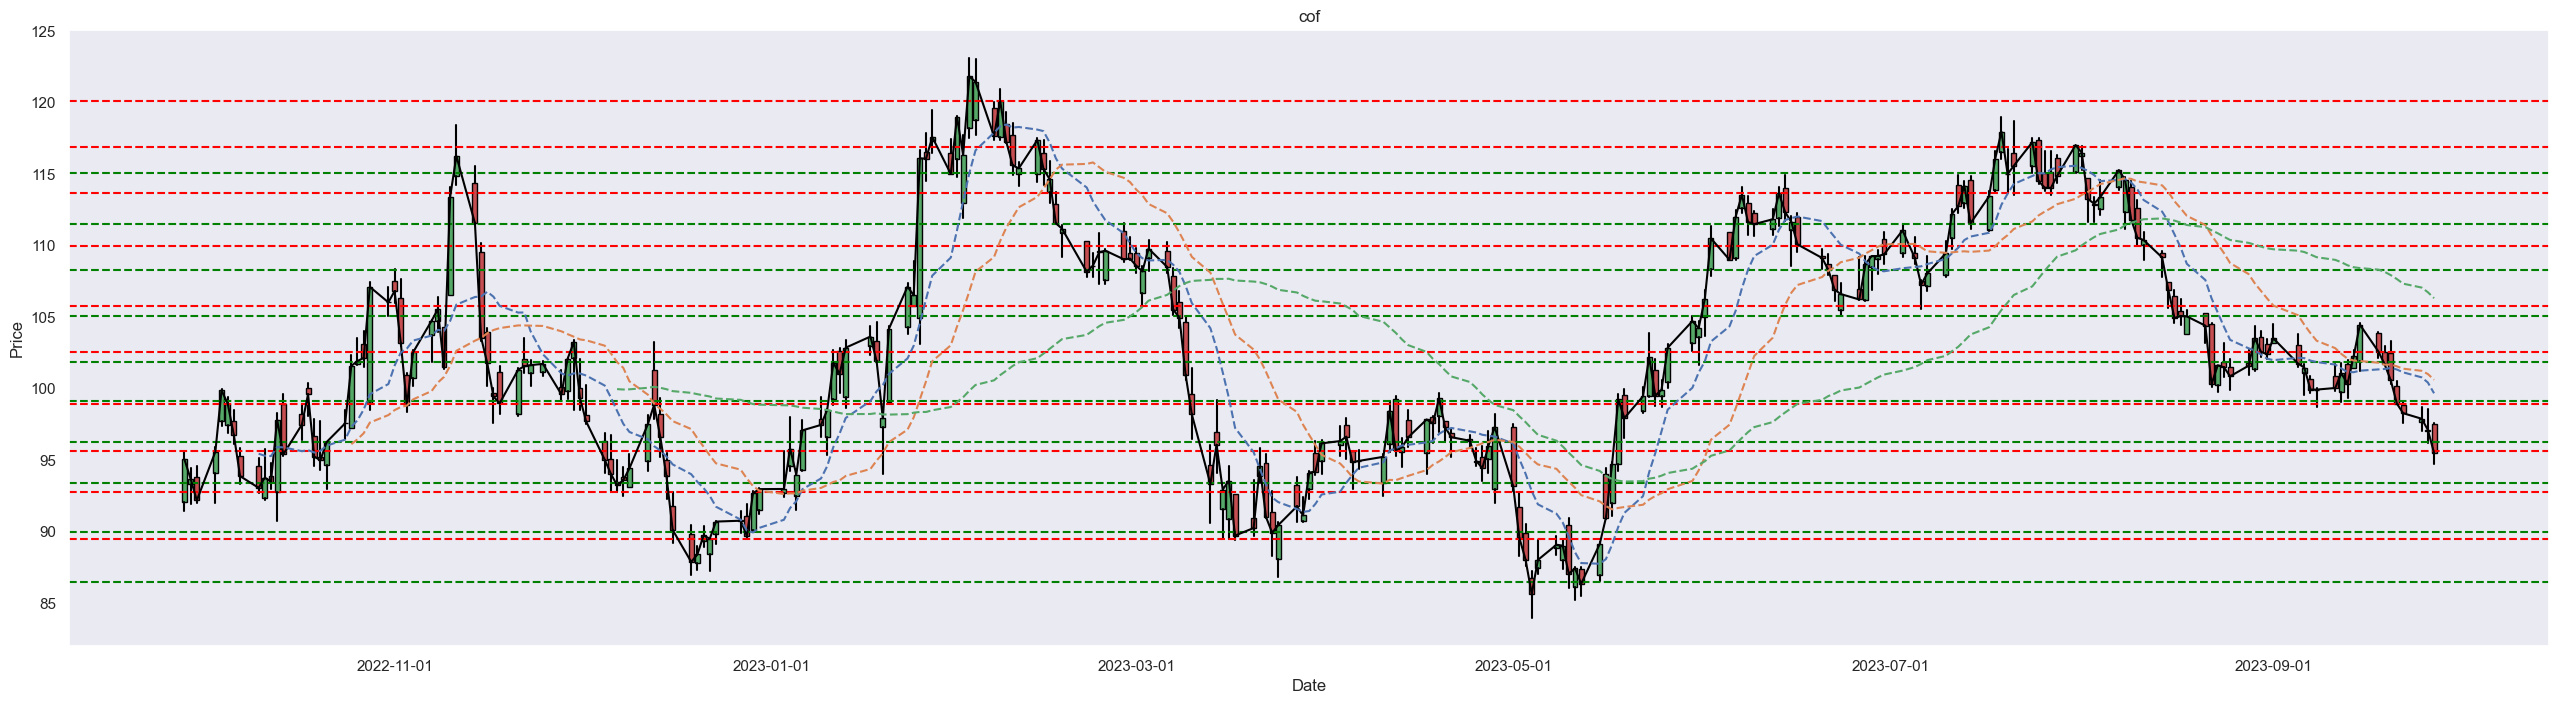

In [9]:
test_option_trading('cof')

AAPL 

2023-09-27
* previous stock price closing 172.0 ~ up 173.8 , down 171.8

* Break / reflect at support / resistance: reflect resistance 174.5

* ITM option traded price: put (strike 175, expire 9/29), 2.44

* Option profitability EOD: 2.28, highest 2.58

Back-test: no strong signal

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 170.43 ~ up 173.81 , down 162.09
[[126.30777825]
 [132.80368524]
 [140.32939425]
 [146.37911673]
 [151.57720032]
 [162.09919983]
 [171.74032297]
 [177.3022584 ]
 [184.65529408]
 [191.54374949]]
[[131.10307488]
 [136.77249781]
 [143.49851933]
 [149.17846132]
 [154.919311  ]
 [164.84280029]
 [173.80807789]
 [179.76781273]
 [187.42217487]
 [194.45499975]]


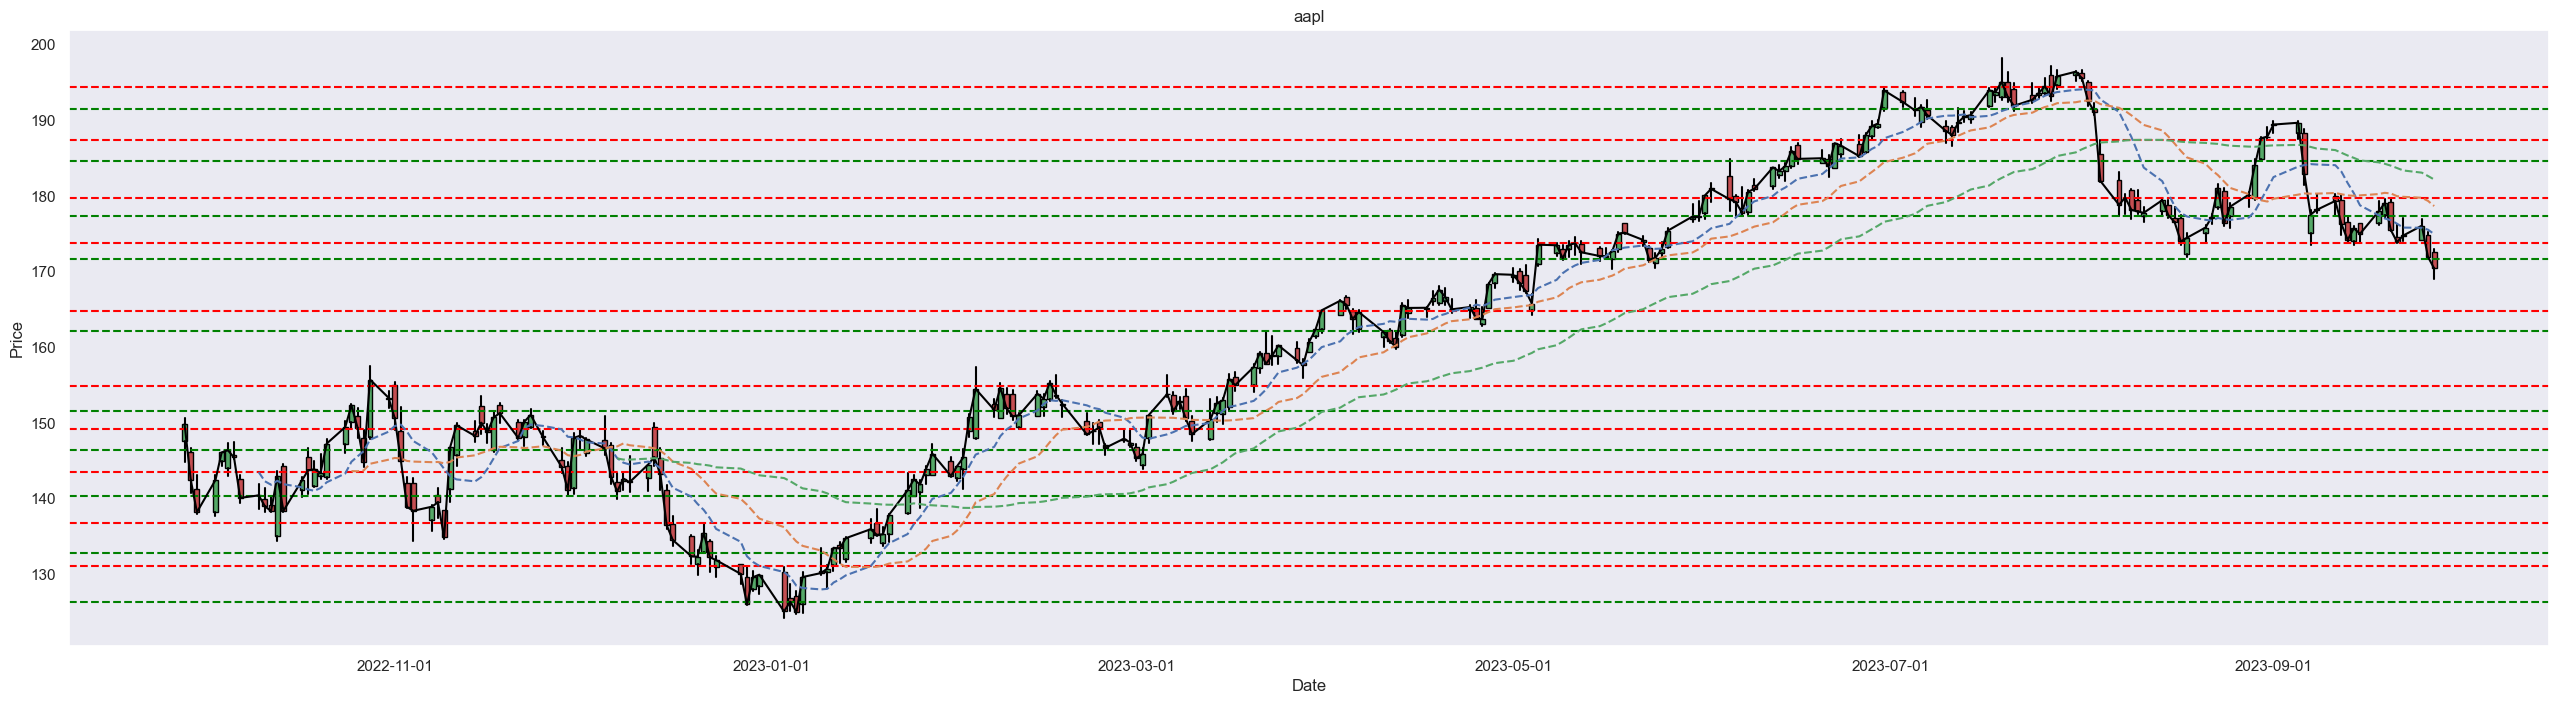

In [10]:
test_option_trading('aapl')

AMD 

2023-09-27
* previous stock price closing 96.0 ~ up 97.9 , down 94.9

* Break / reflect at support / resistance: break resistance 97.7

* ITM option traded price: call (97, expire 9/29) 2.83

* Option profitability EOD: 1.89, highest 2.86

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 98.07 ~ up 106.93 , down 94.93
[[ 57.75434743]
 [ 64.534516  ]
 [ 71.86593747]
 [ 80.39935401]
 [ 88.02350044]
 [ 94.93185142]
 [102.75826064]
 [108.30533346]
 [114.85680054]
 [122.84625053]]
[[ 61.96258065]
 [ 68.52500006]
 [ 74.94559967]
 [ 80.77166706]
 [ 88.25827605]
 [ 97.28483951]
 [106.9289656 ]
 [113.24843812]
 [119.8335302 ]
 [127.43454396]]


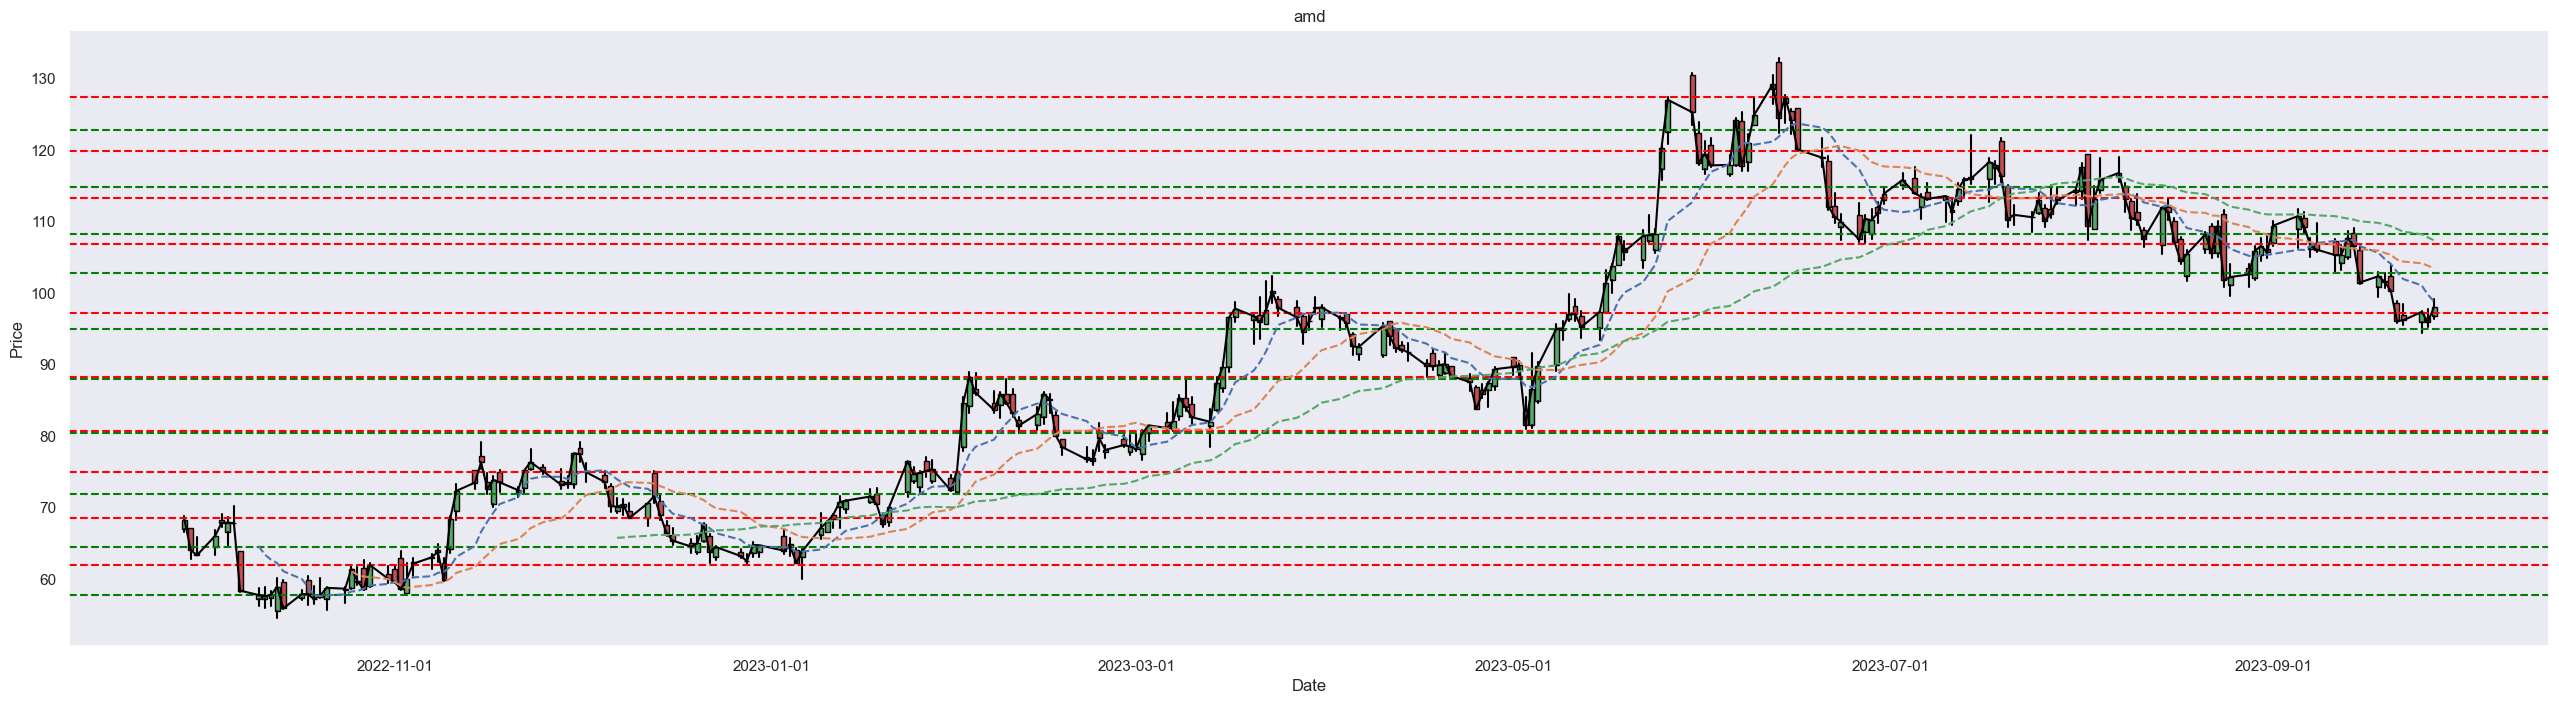

In [11]:
test_option_trading('amd')

BAC 

9/27

* previous stock price closing 27.2 ~ up 27.9 , down 26.3 (min stock price)

* Break / reflect at support / resistance: break support 28.3

* ITM option traded price: put (28, expire 9/29), 0.35

* Option profitability EOD: 0.55

[*********************100%***********************]  1 of 1 completed
2023-09-28
Break all support; record min stock price
* previous stock price closing 27.27 ~ up 27.9 , down 26.31
[[27.36866665]
 [28.28596497]
 [29.22031248]
 [30.50249994]
 [31.56500006]
 [32.52416643]
 [33.9576001 ]
 [35.20352936]
 [36.22176541]
 [37.32090933]]
[[27.89916666]
 [28.79222223]
 [29.65142855]
 [31.05166668]
 [31.95624983]
 [32.83761924]
 [34.41321441]
 [35.45312476]
 [36.48588203]
 [37.73882316]]


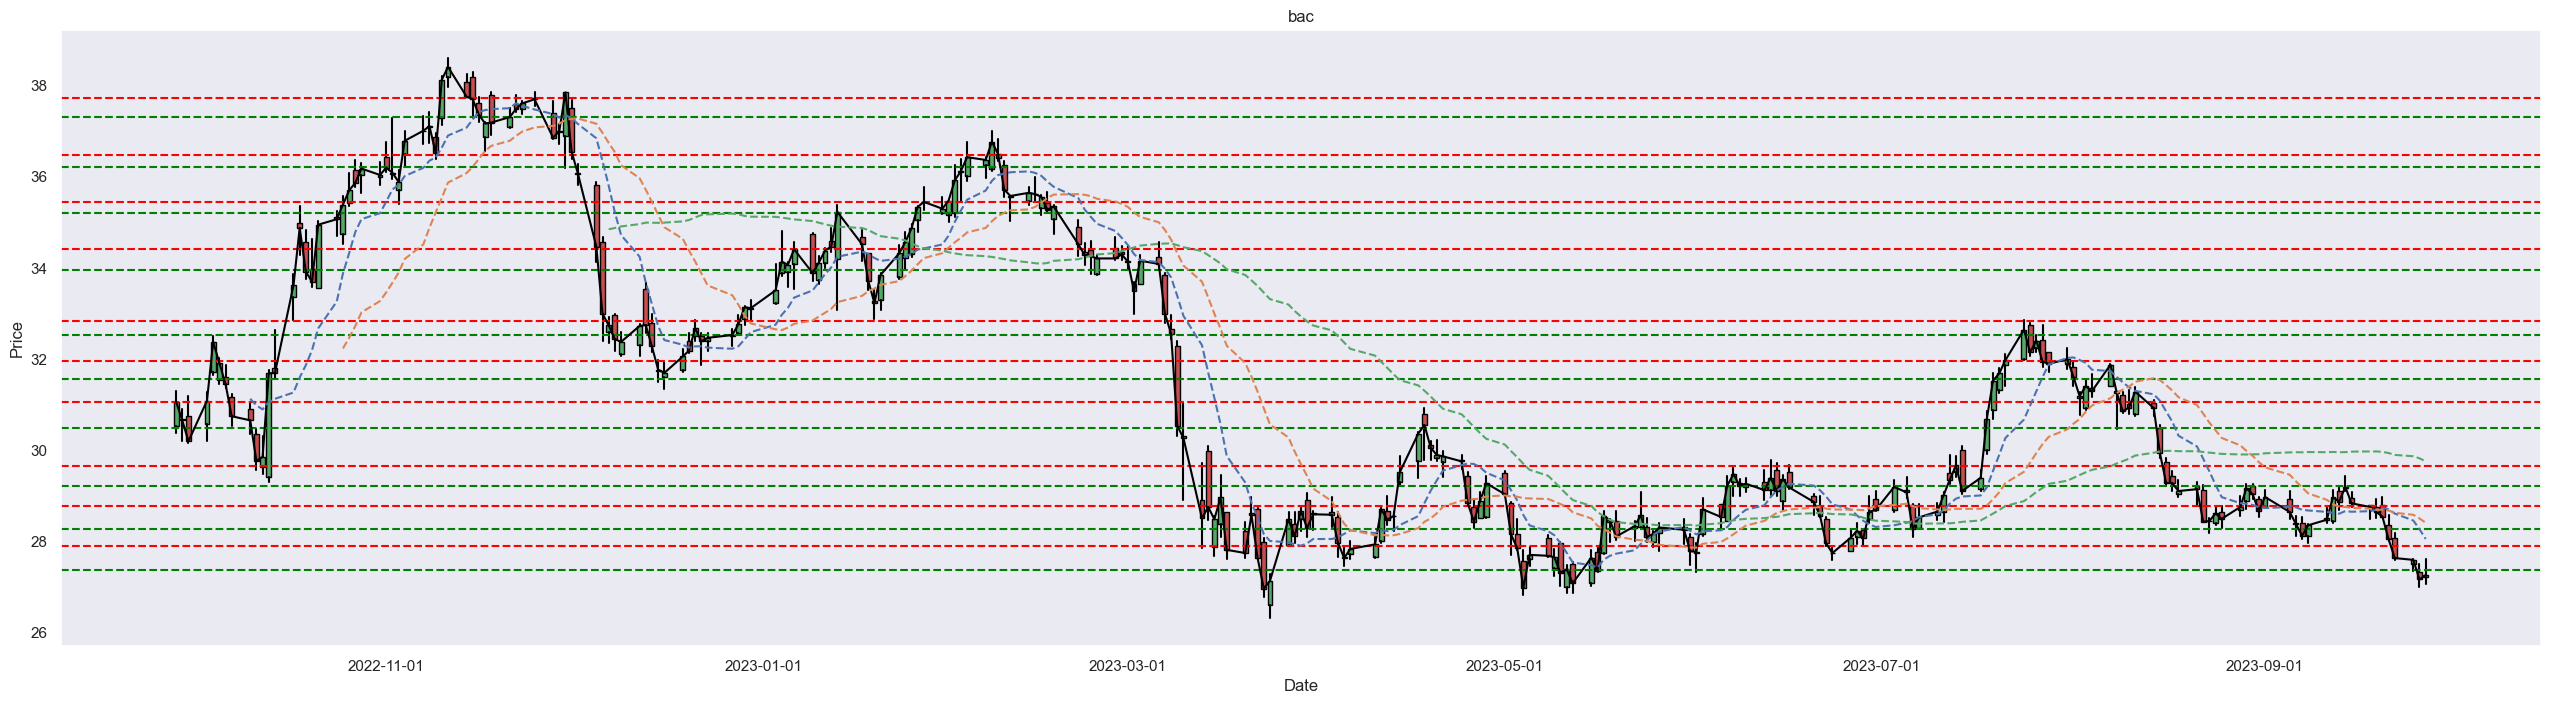

In [12]:
test_option_trading('bac')

NVDA 

2023-09-27
* previous stock price closing 419.1 ~ up 430.5 , down 415.4

* Break / reflect at support / resistance: reflect support 416.5

* ITM option traded price: call (415, expire 9/29), 11.33

* Option profitability EOD: 10.23, highest 11.9

backtest: support break by $4. need a short red/green line to confirm reflect

[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 424.68 ~ up 430.4 , down 416.76
[[127.99657902]
 [160.37200089]
 [201.39529419]
 [229.06750107]
 [266.76499804]
 [291.71642412]
 [383.07307551]
 [416.76151253]
 [446.41106851]
 [471.97363559]]
[[133.95578967]
 [166.8621949 ]
 [209.3588212 ]
 [236.20600052]
 [273.04848318]
 [298.46624947]
 [397.4375    ]
 [430.39911786]
 [461.52606855]
 [488.34333038]]


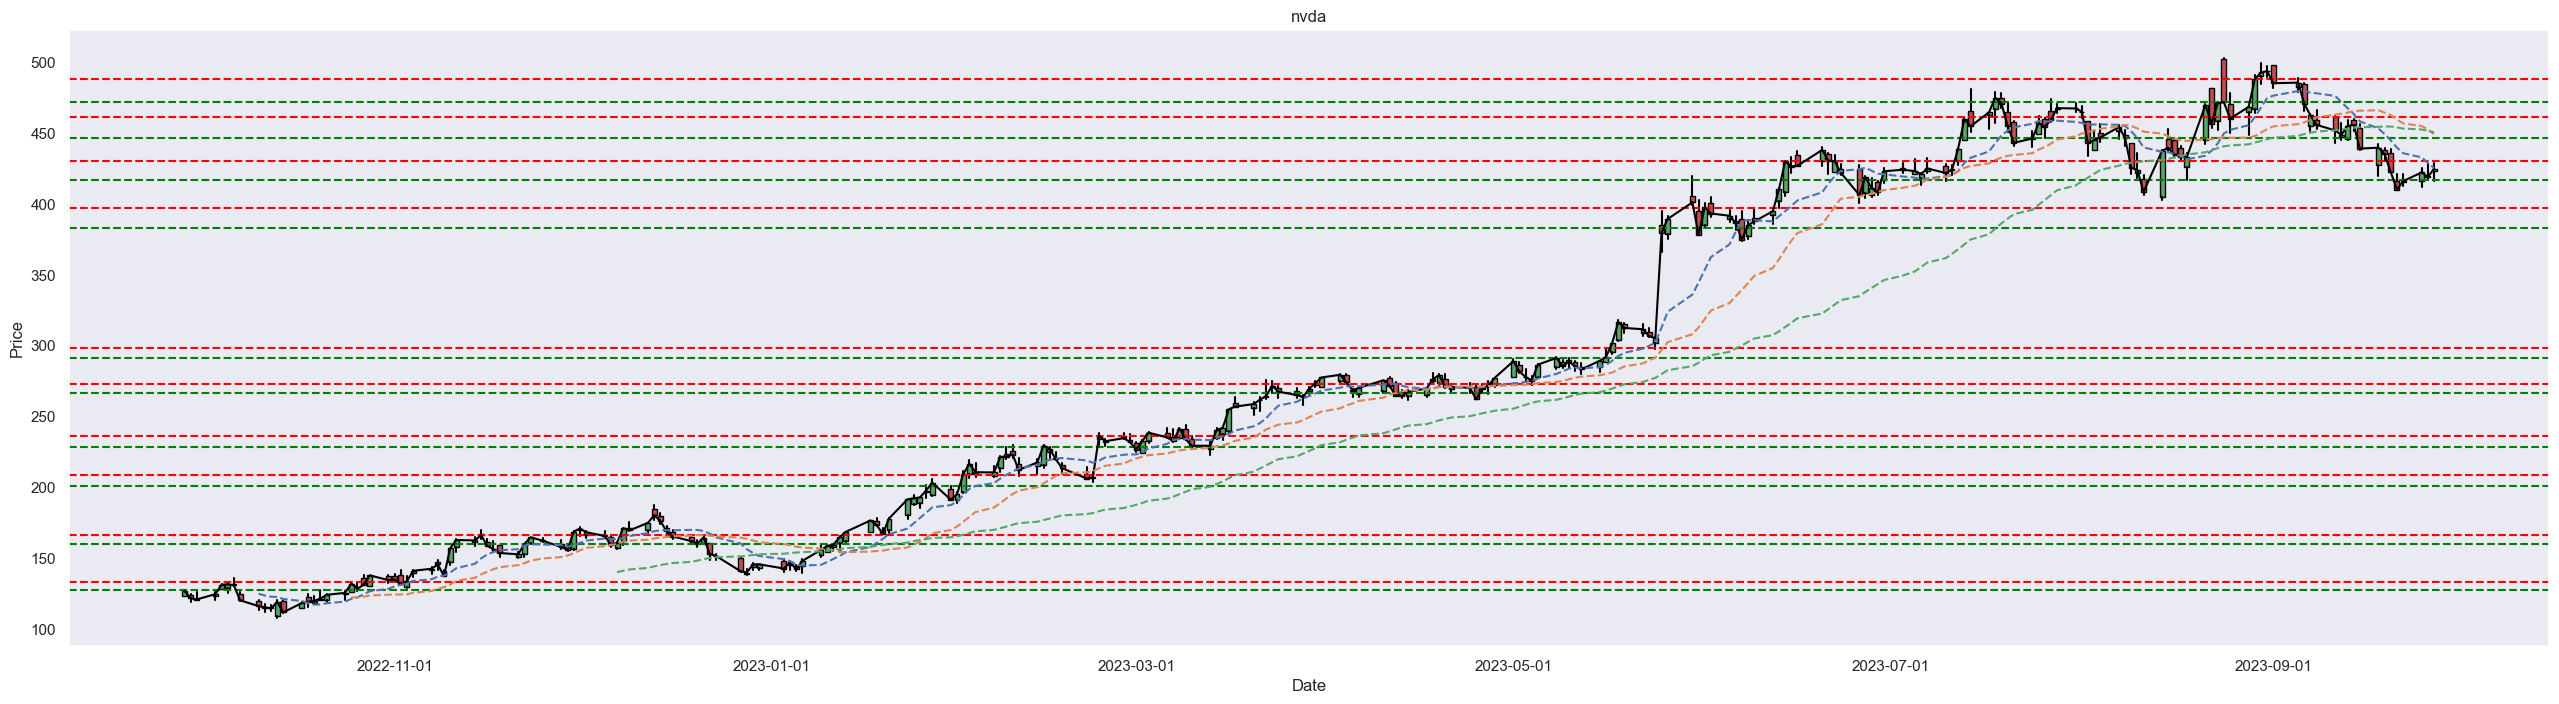

In [13]:
test_option_trading('nvda')

ATT

9/27

* previous stock price closing 15.0 ~ up 15.1 , down 15.0

* Break / reflect at support / resistance: break support 15.2

* ITM option traded price: put (15.5, expire 9/29), 0.4

* Option profitability EOD: 0.42



[*********************100%***********************]  1 of 1 completed
2023-09-28
* previous stock price closing 14.87 ~ up 15.27 , down 14.59
[[14.03050003]
 [14.59777779]
 [15.25111117]
 [15.84304353]
 [16.82285731]
 [17.4754545 ]
 [18.17727251]
 [18.74785723]
 [19.09058829]
 [19.72526309]]
[[14.23000002]
 [14.76190481]
 [15.2695238 ]
 [15.93763161]
 [17.06533343]
 [17.83555561]
 [18.50696951]
 [19.01931033]
 [19.46486499]
 [20.23749995]]


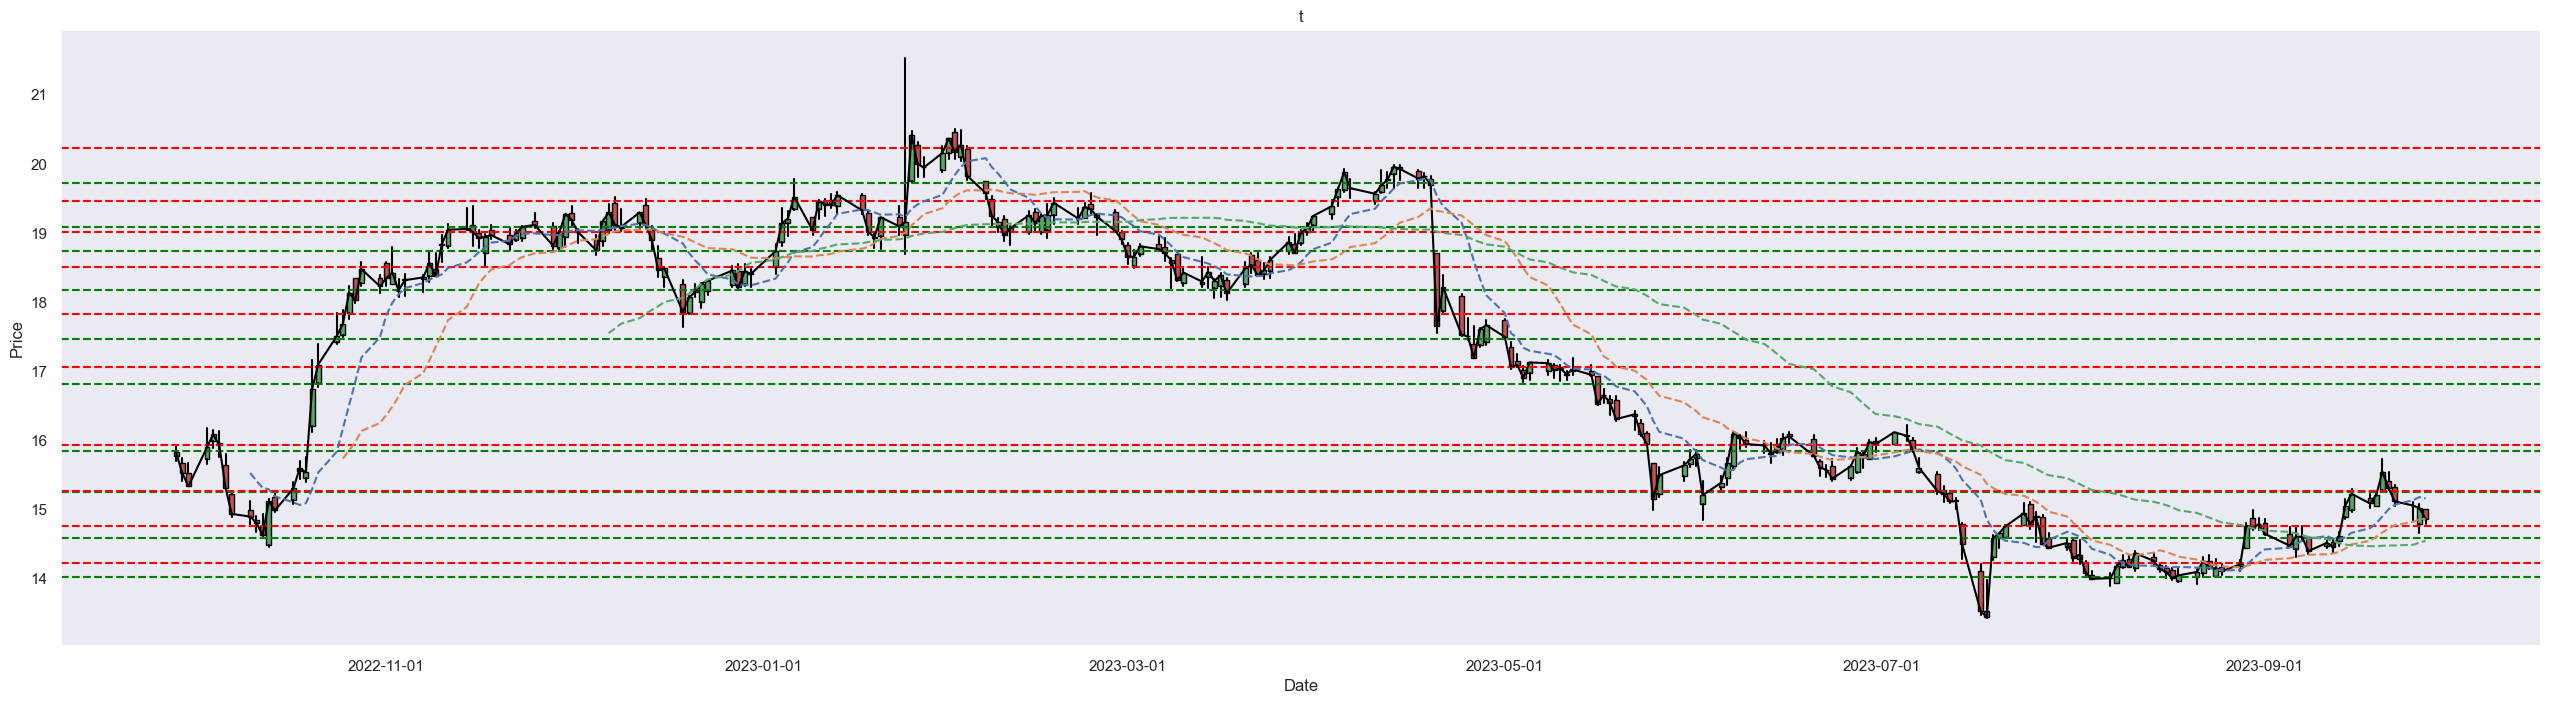

In [14]:
test_option_trading('t')